In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [2]:
# All general imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer 

import keras
!pip install keras_preprocessing
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Bidirectional, GlobalAveragePooling1D, GRU, GlobalMaxPooling1D, concatenate
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, Conv1D, MaxPool1D, Activation, Add

from keras.models import Model, Sequential
from keras.layers.core import SpatialDropout1D

from keras.layers import Layer, Dense, Input, Embedding, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Softmax
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K

from keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import io, os, gc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [4]:
# Loading drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Setting the working directory 
!ls
%cd drive/MyDrive/Project
!pwd

drive  sample_data
/content/drive/MyDrive/Project
/content/drive/MyDrive/Project


In [6]:
#################### Importing FNC Datasets ####################

le = LabelEncoder()
le2 = LabelEncoder()

# Train set
train_df = pd.read_csv('data/train_fnc_with_labels_2nd.csv')
print(train_df.columns)
train_df['Stance'] = le.fit_transform(train_df['Stance']) # agree = 0, disagree = 1
train_df['single_new_emo'] = le2.fit_transform(train_df['single_new_emo']) # emotions agree = 0, disagree = 1
train_df.head()

# Test set
test_df = pd.read_csv('data/test_fnc_with_labels.csv')
print(test_df.columns)
test_df['Stance'] = le.transform(test_df['Stance'])
test_df['single_new_emo'] = le2.transform(test_df['single_new_emo'])
test_df.head()

Index(['id', 'Body', 'Headline', 'Stance', 'Emotion_Labels', 'Novelty_Quora',
       'com_femotion', 'single_new_emo', 'premise_emo', 'hypothesis_emo',
       'novelty_label'],
      dtype='object')
Index(['id', 'Body', 'Headline', 'Stance', 'Emotion_Labels', 'Novelty_Quora',
       'com_femotion', 'single_new_emo', 'premise_emo', 'hypothesis_emo',
       'novelty_label'],
      dtype='object')


,id,Body,Headline,Stance,Emotion_Labels,Novelty_Quora,com_femotion,single_new_emo,premise_emo,hypothesis_emo,novelty_label
0,1964,"Last week, Apple sent out the invites for its ...",EXCLUSIVE: Apple To Unveil The Long-Awaited Re...,0,1,1,1,1,1,0,1
1,1618,Did a woman claiming to have a third breast pl...,3-Boobed Woman a Fake,0,0,0,0,0,1,1,1
2,2316,A fourth grader named Aiden Steward was suspen...,Texas Boy Suspended For 'Threatening' Classmat...,0,0,1,1,1,1,0,1
3,1452,LOS ANGELES (CBS Seattle/AP) — A scorpion stun...,Woman stung by scorpion on Alaska Airlines flight,0,0,0,0,0,1,1,1
4,1636,If the bizarre story about Joan Rivers' doctor...,Disgusting! Joan Rivers Doc Gwen Korovin’s Sic...,1,0,1,0,0,1,1,1


In [7]:
# Importing BERT embeddings

print("Train data: ")
pre_bert_fnc = np.load("bert/pre_bert_fnc.npy")
hyp_bert_fnc = np.load("bert/hyp_bert_fnc.npy")
print('Premise', pre_bert_fnc.shape)
print('Hypothesis', hyp_bert_fnc.shape)

print("Test data: ")
pre_bert_fnc_test = np.load("bert/pre_bert_test_fnc.npy")
hyp_bert_fnc_test = np.load("bert/hyp_bert_test_fnc.npy")
print('Premise', pre_bert_fnc_test.shape)
print('Hypothesis', hyp_bert_fnc_test.shape)

Train data: 
Premise (3615, 768)
Hypothesis (3615, 768)
Test data: 
Premise (2600, 768)
Hypothesis (2600, 768)


In [8]:
# train_lst_1 = train_df['Body'].tolist()
# train_lst_2 = train_df['Headline'].tolist()
# print('Train Headline: ', len(train_lst_2))
# uq_tr_1 = list(set(train_lst_1))
# uq_tr_2 = list(set(train_lst_2))
# train_merged = uq_tr_1 + uq_tr_2
# print('Train length is', len(train_merged))

# test_lst_1 = test_df['Body'].tolist()
# test_lst_2 = test_df['Headline'].tolist()
# uq_ts_1 = list(set(test_lst_1))
# uq_ts_2 = list(set(test_lst_2))
# test_merged = uq_ts_1 + uq_ts_2
# print('Test length is', len(test_merged))

# total_dataset = train_merged + test_merged
# print('Total dataset length is', len(total_dataset))

In [9]:
# train_max_1 = max([len(s) for s in train_lst_1])
# train_max_2 = max([len(s) for s in train_lst_2])
# train_avg_1 = int(np.average([len(s) for s in train_lst_1]))
# train_avg_2 = int(np.average([len(s) for s in train_lst_2]))
# train_min_1 = min([len(s) for s in train_lst_1])
# train_min_2 = min([len(s) for s in train_lst_2])
# print("Train set: ")
# print('Body -> Max: ', train_max_1, 'Avg: ', train_avg_1, 'Min: ', train_min_1)
# print('Headline -> Max: ', train_max_2, 'Avg: ', train_avg_2, 'Min: ', train_min_2)
# test_max_1 = max([len(s) for s in test_lst_1])
# test_max_2 = max([len(s) for s in test_lst_2])
# test_avg_1 = int(np.average([len(s) for s in test_lst_1]))
# test_avg_2 = int(np.average([len(s) for s in test_lst_2]))
# test_min_1 = min([len(s) for s in test_lst_1])
# test_min_2 = min([len(s) for s in test_lst_2])
# print("Test set: ")
# print('Body -> Max: ', test_max_1, 'Avg: ', test_avg_1, 'Min: ', test_min_1)
# print('Headline -> Max: ', test_max_2, 'Avg: ', test_avg_2, 'Min: ', test_min_2)

# MAX_LENGTH = 100

In [10]:
# import string
# !pip install nltk
# import nltk
# from nltk.tokenize import  word_tokenize

# contr_dict = {"I\'m": "I am",
#             "won\'t": "will not",
#             "\'s" : "", 
#             "\'ll":"will",
#             "\'ve":"have",
#             "n\'t":"not",
#             "\'re": "are",
#             "\'d": "would",
#             "y'all": "all of you",
#             "\' " : " ",
#             " \'" : " "}

# known_typos = {
#     "accordin ":"according ",
#     "entirel ":"entirely ",
#     "electri ":"electric"
# }

# def encode_char(text):
#     text = text.replace(u"\u201d",'"') # replace unicode quotation
#     text = text.replace(u"\u201c",'"')
#     text = text.replace(u"\u2018","'")
#     text = text.replace(u"\u2019","'")
#     if u"\u201d" in text or u"\u201c" in text or u"\u2018" in text or u"\u2019" in text:
#       print(text)
#     encoded_string = text.encode("ascii", "ignore")
#     text = encoded_string.decode()
#     return text

# def correct_typos(text):
#     text = text + " "
#     for typo in known_typos:
#       text = text.replace(typo, " "+known_typos[typo])
#     return text

# def remove_html(text):
#     text = text.replace("< i >", "")
#     text = text.replace("< / i >", "")
#     return text

# def remove_numbers(text):
#     no_digits = ""
#     for i in text:
#         if not i.isdigit():
#             no_digits += i
#     return no_digits

# def remove_punctuation(text):
#     punctuationfree = ""
#     for i in range(len(text)):
#       if text[i] not in string.punctuation:
#         punctuationfree += text[i]
#       else:
#         if i < (len(text)-1) and text[i+1] != " ": # add space after punctuation
#           punctuationfree += " "
#     return punctuationfree

# def tokenization(text):
#     tokens = word_tokenize(text)
#     return tokens

# def remove_stopwords(stopwords, tokens):
#     result = [t for t in tokens if t not in stopwords]
#     return result

# def tokens_to_text(tokens):
#     result = " ".join(t for t in tokens)
#     return result

# # remove apostrophes and replaces contractions with full words
# def replace_contractions(text, contr_dict=contr_dict):
#     text = text.lower()
#     for char in ["′","ʼ","`","՚","ʼ","ߴ","ߵ","＇", '“','”',"\'", "’", "‘"]:
#       text = text.replace(char, "\'")
#     for i in range(len(text)):
#       if text[i] == "\'" and (i == 0 or text[i-1] == "."):
#         text[i] == ""
#     text = text.replace(" \'"," ")
#     text = text.replace("\' "," ")
#     for contr in contr_dict:
#       text = text.replace(contr, " "+contr_dict[contr])
#     text = text.replace("\'","")
#     return text

# def text_preprocessing(texts):
#   new_texts = []
#   for text in texts:
#       text = encode_char(text)
#       # text = remove_html(text)
#       text = remove_numbers(text)
#       text = replace_contractions(text)
#       # text = remove_punctuation(text)
#       text = correct_typos(text)
#       # tokens =  tokenization(text)
#       # stopwords = nltk.corpus.stopwords.words('english')
#       # tokens = remove_stopwords(stopwords, tokens)
#       # text = tokens_to_text(tokens)
#       new_texts.append(text)
#   return new_texts

# total_dataset = text_preprocessing(total_dataset)

In [11]:
# from nltk import tokenize
# import nltk
# nltk.download('punkt')

# n_sent_lst = []
# n_words_lst = []
# for text in total_dataset: # count max number of sentences and max number of words in a sentence
#   sentences = tokenize.sent_tokenize(text)
#   n_sent_lst.append(len(sentences))
#   n_words = 0
#   for sent in sentences:
#     n = len(tokenize.word_tokenize(sent))
#     if n > n_words:
#       n_words = n
#   n_words_lst.append(n_words)

# max_n_sent = max(n_sent_lst)
# max_n_words = max(n_words_lst)

# print(max_n_sent) # max num of sentences
# print(max_n_words) # max num of words in a sentence

# if max_n_sent > 10:
#   m = 10
# elif max_n_sent >= 5:
#   m = max_n_sent
# else:
#   m = 5

# if max_n_words > 50:
#   n = 50
# elif max_n_words >= 10:
#   n = max_n_words
# else:
#   n = 10

# #MAX_LENGTH = m*n
# MAX_LENGTH = 150
# print(MAX_LENGTH)

In [12]:
# # Defining the tokenizer
# def get_tokenizer(vocabulary_size):
#   print('Training tokenizer...')
#   tokenizer = Tokenizer(num_words = vocabulary_size)
#   tweet_text = []
#   print('Read {} Sentences'.format(len(total_dataset)))
#   tokenizer.fit_on_texts(total_dataset)
#   return tokenizer

In [13]:
# def process_glove_line(line, dim):
#     word = None
#     embedding = None
#     try:
#       splitLine = line.split()
#       word = " ".join(splitLine[:len(splitLine)-dim])
#       embedding = np.array([float(val) for val in splitLine[-dim:]])
#     except:
#       print(line)
#     return word, embedding

# # For getting the embedding matrix
# def get_embeddings():
#   print('Generating embeddings matrix...')
#   embeddings_file = 'glove.6B.300d.txt'
#   embeddings_index = dict()
#   with open(embeddings_file, 'r', encoding="utf-8") as infile:
#     for line in infile:
#       word, vector = process_glove_line(line, 300)
#       embeddings_index[word] = vector
# 	# create a weight matrix for words in training docs
#   vocabulary_size = len(embeddings_index)
#   embeddinds_size = list(embeddings_index.values())[0].shape[0]
#   print('Vocabulary = {}, embeddings = {}'.format(vocabulary_size, embeddinds_size))
#   tokenizer = get_tokenizer(vocabulary_size)
#   embedding_matrix = np.zeros((vocabulary_size, embeddinds_size))
#   considered = 0
#   total = len(tokenizer.word_index.items())
#   oov = []
#   for word, index in tokenizer.word_index.items():
#     if index > vocabulary_size - 1:
#       print(word, index)
#       continue
#     else:
#       embedding_vector = embeddings_index.get(word)
#       if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector
#         considered += 1
#       else:
#          oov.append(word)
#   print('Considered ', considered, 'Left ', total - considered)	
#   return embedding_matrix, tokenizer, embeddings_index, oov

In [20]:
def get_labels(input_df):
  print('Loading data')
  Y_fnc = input_df['Stance'].tolist()
  Y_nv = input_df["novelty_label"].values
  Y_em = input_df["single_new_emo"].values
  # Y_nv = input_df["Novelty_Quora"].values
  # Y_em = input_df["com_femotion"].values
  assert len(Y_fnc) == len(Y_nv) == len(Y_em)
  Y_fnc = np.array(Y_fnc)
  Y_nv = np.array(Y_nv)
  Y_em = np.array(Y_em)
  return Y_fnc, Y_nv, Y_em

In [15]:
# embedding_matrix, tokenizer, embeddings_index, oov = get_embeddings()

In [16]:
#print(tokenizer.word_index)

In [17]:
# def get_oov_freq(oov, total_dataset):
#   oov_freq = dict()
#   for s in total_dataset:
#     for word in oov:
#       count = s.count(word)
#       if count > 0:
#         try:
#           oov_freq[word] += count
#         except KeyError:
#           oov_freq[word] = count
#   return oov_freq

# def show_oov_words(oov_freq, num_to_show=30):
#     # Sort oov words by their frequency in the text
#     sorted_oov = sorted(oov_freq.items(), key=lambda x:x[1], reverse=True)
#     # Show oov words and their frequencies
#     if (len(sorted_oov)>0):
#         print("oov words:")
#         for pair in sorted_oov[:num_to_show]:
#           print("%s\t%s"%(pair[0], pair[1]))
#     else:
#         print("No words were out of vocabulary.")
#     return len(sorted_oov)

In [18]:
# oov_freq = get_oov_freq(oov, total_dataset)
# oov_len = show_oov_words(oov_freq, 100)

In [21]:
# read train data
Y_fnc, Y_nv, Y_em = get_labels(train_df)

Loading data


Class balance for train data: 


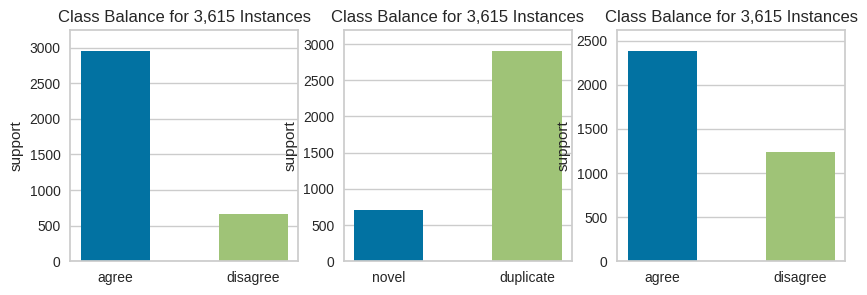

In [22]:
#!pip install yellowbrick
from yellowbrick.target import ClassBalance
import matplotlib.pyplot as plt

print("Class balance for train data: ")
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(10,3))

classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_fnc = ClassBalance(labels=classes, ax=ax1)
visualiser_fnc.fit(Y_fnc)
visualiser_fnc.finalize()

visualiser_nv = ClassBalance(labels=['novel', 'duplicate'], ax=ax2) # 0 = novel, 1 = duplicate
visualiser_nv.fit(Y_nv)
visualiser_nv.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax3) # 0 = agree, 1 = disagree
visualiser_em.fit(Y_em)
visualiser_em.finalize()

In [23]:
print("FNC train data class balance: ")
unique, counts = np.unique(Y_fnc, return_counts=True)
dict(zip(unique, counts))

FNC train data class balance: 


{0: 2948, 1: 667}

In [25]:
# read test data
Y_fnc_test, Y_nv_test, Y_em_test = get_labels(test_df)

Loading data


Class distribution for test data: 


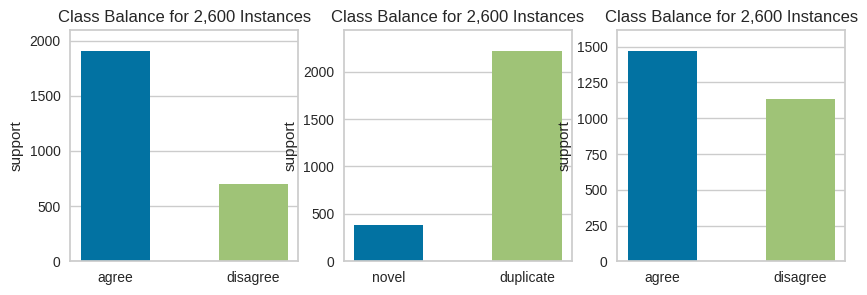

In [26]:
print("Class distribution for test data: ")
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(10,3))
classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_fnc = ClassBalance(labels=classes, ax=ax1)
visualiser_fnc.fit(Y_fnc_test)
visualiser_fnc.finalize()

visualiser_nv = ClassBalance(labels=['novel', 'duplicate'], ax=ax2)
visualiser_nv.fit(Y_nv_test)
visualiser_nv.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax3)
visualiser_em.fit(Y_em_test)
visualiser_em.finalize()

In [27]:
print("FNC test data class balance: ")
unique, counts = np.unique(Y_fnc_test, return_counts=True)
dict(zip(unique, counts))

FNC test data class balance: 


{0: 1903, 1: 697}

In [28]:
# Creating one-hot encodings
y_train_nv = keras.utils.to_categorical(Y_nv)
# print(y_train_nv)
y_train_em = keras.utils.to_categorical(Y_em)
# print(y_train_em)
y_train_fnc = keras.utils.to_categorical(Y_fnc)
# print(y_train_fnc)
y_test_nv = keras.utils.to_categorical(Y_nv_test)
# print(y_test_nv)
y_test_em = keras.utils.to_categorical(Y_em_test)
# print(y_test_em)
y_test_fnc = keras.utils.to_categorical(Y_fnc_test)
# print(y_test_fnc)

In [29]:
from sklearn.model_selection import train_test_split
VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527
x1_train, x1_val, \
x2_train, x2_val, \
y_train_nv, y_val_nv, \
y_train_em, y_val_em, \
y_train_fnc, y_val_fnc = \
    train_test_split(
        pre_bert_fnc, hyp_bert_fnc,  
        y_train_nv, y_train_em, 
        y_train_fnc,
        test_size=VALIDATION_RATIO, 
        random_state=RANDOM_STATE
)

In [30]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
# print(f"x1_train_bert : {x1_train_bert.shape}")
# print(f"x2_train_bert : {x2_train_bert.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
# print(f"x1_val_bert:   {x1_val_bert.shape}")
# print(f"x2_val_bert :   {x2_val_bert.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (3253, 768)
x2_train: (3253, 768)
----------
x1_val:   (362, 768)
x2_val:   (362, 768)
----------
Test Set


In [31]:
NUM_CLASSES = 2

In [32]:
################# Disagreement detection using BERT ##################

pre_input = Input(
    shape=(768, ), 
    dtype='float32')
hyp_input = Input(
    shape=(768, ), 
    dtype='float32')

hyp_bert = Dense(units=256, activation='tanh', name = 'dense_hyp')(hyp_input)
pre_bert = Dense(units=256, activation='tanh', name = 'dense_pre')(pre_input)

# Concatenating BERT embeddings of premise and hypothesis
comb_pre_hyp = concatenate([pre_bert, hyp_bert],axis=-1)

# Dense layer
dense_out = Dense(units=64, activation='tanh', name = 'dense_0')(comb_pre_hyp)

# Classification layer
predictions =  Dense(units=NUM_CLASSES, activation='softmax',name = 'dense_1')(dense_out)

model_bert_dg = Model(
    inputs=[pre_input, hyp_input], 
    outputs=predictions)

model_bert_dg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 dense_pre (Dense)              (None, 256)          196864      ['input_1[0][0]']                
                                                                                                  
 dense_hyp (Dense)              (None, 256)          196864      ['input_2[0][0]']                
                                                                                              

In [33]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/50)
model_bert_dg.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='fnc_bert_disagreement.h5', verbose=1, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [34]:
# BERT for disagreement detection
BATCH_SIZE = 256
NUM_EPOCHS = 50
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = model_bert_dg.fit(x=[x1_train, x2_train],
                    y=y_train_fnc,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(
                      [x1_val, x2_val], 
                      y_val_fnc
                    ),
                    shuffle=True,
                    callbacks=stop,
          )

Epoch 1/50
13/13 [==============================] - 4s 22ms/step - loss: 0.6336 - accuracy: 0.7811 - val_loss: 0.4739 - val_accuracy: 0.8066
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 0.4591 - accuracy: 0.8171 - val_loss: 0.4687 - val_accuracy: 0.8066
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 0.4312 - accuracy: 0.8149 - val_loss: 0.4474 - val_accuracy: 0.8011
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.4062 - accuracy: 0.8251 - val_loss: 0.4290 - val_accuracy: 0.8149
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 0.3741 - accuracy: 0.8285 - val_loss: 0.4088 - val_accuracy: 0.8204
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.3454 - accuracy: 0.8509 - val_loss: 0.3842 - val_accuracy: 0.8508
Epoch 7/50
13/13 [==============================] - 0s 6ms/step - loss: 0.3303 - accuracy: 0.8534 - val_loss: 0.3703 - val_accuracy: 0.8591
Epoch 8/50
13/13 [=

In [36]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
predictions = model_bert_dg.predict(
    [pre_bert_fnc_test, hyp_bert_fnc_test])

82/82 [==============================] - 0s 2ms/step


In [37]:
# Result Labels
res_df = pd.DataFrame()

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    
    # Loss
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    losses = ['loss','val_loss']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[losses[i]], 'g')
      ax.set_title(losses[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel(losses[i])
      i += 1
   
    plt.show()

    # Accuracy
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    accuracies = ['accuracy','val_accuracy']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[accuracies[i]], 'b')
      ax.set_title(accuracies[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel(accuracies[i])
      i += 1
   
    plt.show()

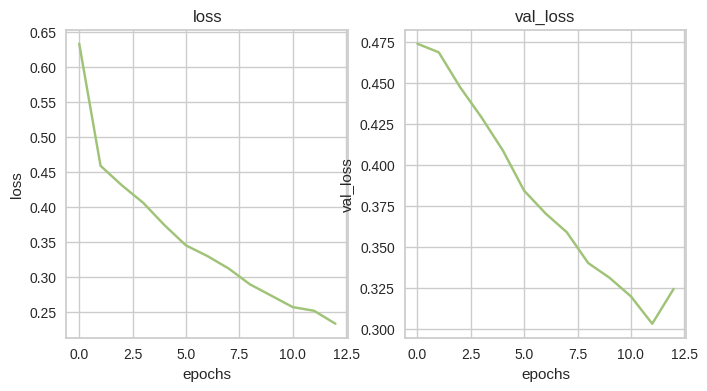

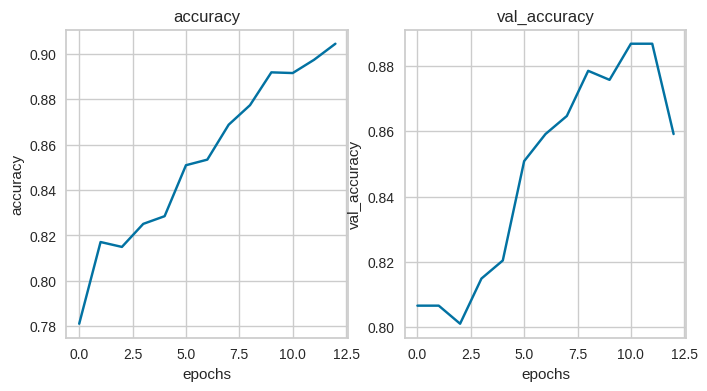

In [39]:
#print(history.history['bd_loss'])
plot_history(history)

In [40]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [41]:
y_pred = [idx for idx in np.argmax(predictions, axis=1)]
res_df['DG_Labels'] = y_pred
#print(y_pred)
print('FNC Accuracy is')
print(metrics.accuracy_score(Y_fnc_test, y_pred)*100)
print(classification_report(Y_fnc_test, y_pred, target_names = ['agreed', 'disagreed']))

FNC Accuracy is
73.11538461538461
              precision    recall  f1-score   support

      agreed       0.75      0.94      0.84      1903
   disagreed       0.50      0.16      0.24       697

    accuracy                           0.73      2600
   macro avg       0.62      0.55      0.54      2600
weighted avg       0.68      0.73      0.68      2600



[[1792  111]
 [ 588  109]]


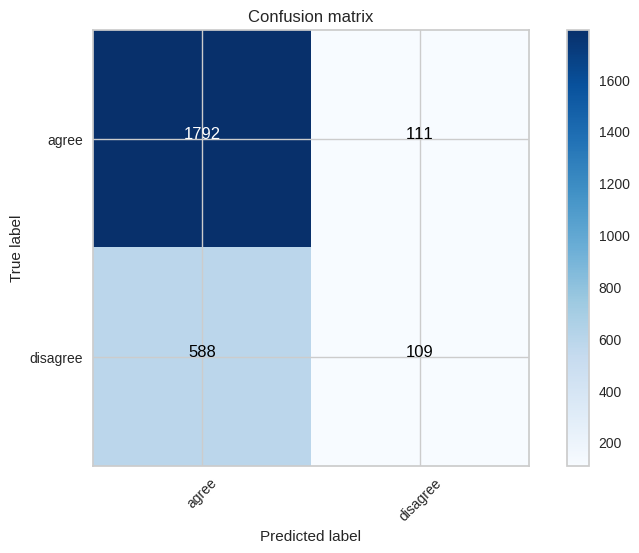

In [42]:
cnf_matrix = confusion_matrix(Y_fnc_test,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=le.inverse_transform(np.arange(2)))

In [43]:
################# Emotion recognition using BERT ##################

pre_input_em = Input(
    shape=(768, ), 
    dtype='float32')
hyp_input_em = Input(
    shape=(768, ), 
    dtype='float32')

hyp_bert_em = Dense(units=256, activation='tanh', name = 'dense_hyp_em')(hyp_input_em)
pre_bert_em = Dense(units=256, activation='tanh', name = 'dense_pre_em')(pre_input_em)

# Concatenating BERT embeddings of premise and hypothesis
comb_pre_hyp_em = concatenate([pre_bert_em, hyp_bert_em],axis=-1)

# Dense layer
dense_out_em = Dense(units=64, activation='tanh', name = 'dense_0_em')(comb_pre_hyp_em)

# Classification layer
predictions_em =  Dense(units=NUM_CLASSES, activation='softmax',name = 'dense_1')(dense_out_em)

model_bert_em = Model(
    inputs=[pre_input_em, hyp_input_em], 
    outputs=predictions_em)

model_bert_em.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 dense_pre_em (Dense)           (None, 256)          196864      ['input_3[0][0]']                
                                                                                                  
 dense_hyp_em (Dense)           (None, 256)          196864      ['input_4[0][0]']                
                                                                                            

In [44]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/50)
model_bert_em.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='fnc_bert_emotion.h5', verbose=1, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [49]:
# BERT for emotion recognition
BATCH_SIZE = 256
NUM_EPOCHS = 50
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = model_bert_em.fit(x=[x1_train, x2_train],
                    y=y_train_em,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(
                      [x1_val, x2_val], 
                      y_val_em
                    ),
                    shuffle=True,
                    callbacks=stop,
          )

Epoch 1/50
13/13 [==============================] - 0s 9ms/step - loss: 0.5804 - accuracy: 0.7061 - val_loss: 0.5541 - val_accuracy: 0.7099
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 0.5466 - accuracy: 0.7338 - val_loss: 0.5324 - val_accuracy: 0.7459
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 0.5181 - accuracy: 0.7495 - val_loss: 0.5133 - val_accuracy: 0.7541
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.4938 - accuracy: 0.7642 - val_loss: 0.4876 - val_accuracy: 0.7956
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 0.4665 - accuracy: 0.7897 - val_loss: 0.4601 - val_accuracy: 0.8011
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.4514 - accuracy: 0.7888 - val_loss: 0.4632 - val_accuracy: 0.7901


In [50]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
predictions_em = model_bert_em.predict(
    [pre_bert_fnc_test, hyp_bert_fnc_test])

82/82 [==============================] - 0s 2ms/step


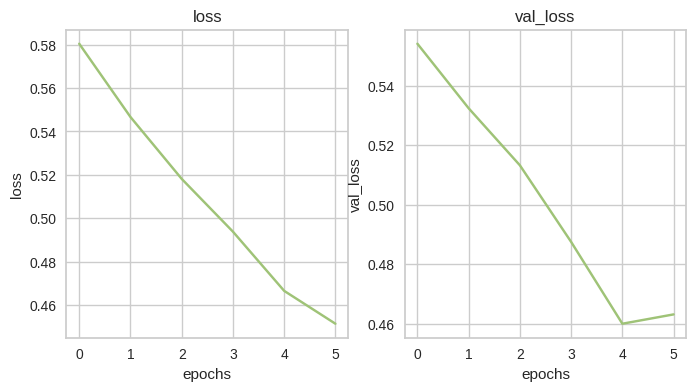

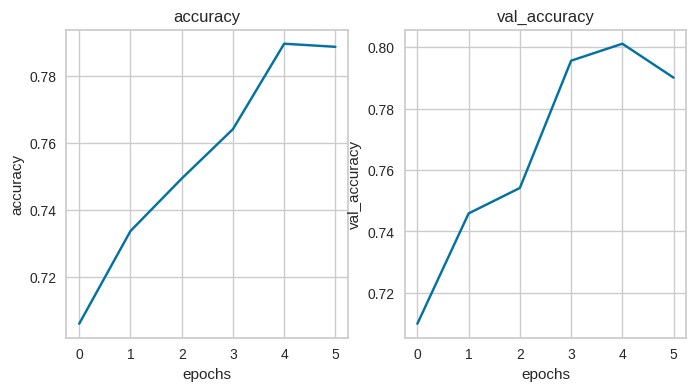

In [51]:
plot_history(history)

In [52]:
y_pred_em = [idx for idx in np.argmax(predictions_em, axis=1)]
res_df['EM_Labels'] = y_pred_em
print('Emotion Accuracy is')
print(metrics.accuracy_score(Y_em_test, y_pred_em)*100)
print(classification_report(Y_em_test, y_pred_em, target_names = ['agreed', 'disagreed']))

Emotion Accuracy is
60.15384615384616
              precision    recall  f1-score   support

      agreed       0.60      0.90      0.72      1468
   disagreed       0.62      0.22      0.33      1132

    accuracy                           0.60      2600
   macro avg       0.61      0.56      0.52      2600
weighted avg       0.61      0.60      0.55      2600



[[1314  154]
 [ 882  250]]


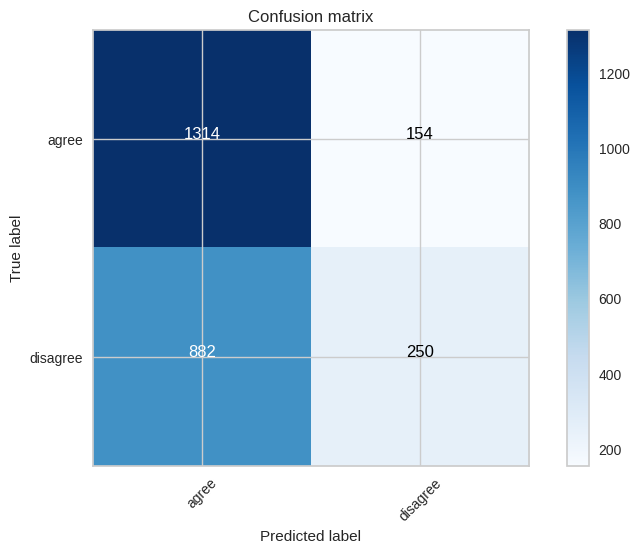

In [53]:
cnf_matrix = confusion_matrix(Y_em_test,y_pred_em)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=le2.inverse_transform(np.arange(2)))

In [54]:
# Saving the labels
res_df.to_csv("baselines/outputs/FNC_Baseline_BERT_results.csv", index = False)